In [ ]:
"""
Purpose: To put all of the rules together
to autoatically proofread a cell


"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import sys
sys.path.append("/meshAfterParty/")

In [3]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du

import numpy as np

import proofreading_utils as pru

import preprocessing_vp2 as pre

# -- For the axon classification --

import neuron_searching as ns

import skeleton_utils as sk

import numpy_utils as nu

import networkx_utils as xu

import system_utils as su

import classification_utils as clu
import proofreading_utils as pru

INFO - 2021-02-02 22:18:39,872 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-02-02 22:18:39,874 - settings - Setting database.user to celiib
INFO - 2021-02-02 22:18:39,875 - settings - Setting database.password to newceliipass
INFO - 2021-02-02 22:18:39,878 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-02-02 22:18:39,879 - settings - Setting enable_python_native_blobs to True
INFO - 2021-02-02 22:18:39,890 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-02-02 22:18:40,152 - settings - Setting enable_python_native_blobs to True


In [4]:
minnie,schema = du.configure_minnie_vm()

INFO - 2021-02-02 22:18:40,232 - settings - Setting enable_python_native_blobs to True
INFO - 2021-02-02 22:18:40,493 - settings - Setting enable_python_native_blobs to True


# Importing the Neuron

In [5]:
import datajoint as dj
dj.config["display.limit"] = 20
curr_table = minnie.Decomposition & "process_version = 4" & "n_limbs>5" & "n_error_limbs>0" & "n_somas>1"
curr_table

INFO - 2021-02-02 22:18:40,558 - settings - Setting display.limit to 20


segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),multiplicity the number of somas found for this base segment,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691135012398582,0,0.25,30.00,4,0,1,=BLOB=,1376990,2794781,0,3,1,3,2,7,332,193,13857599.090995071,7698499.767603829,24782.936,182.056,175.907,512.504,498.037,5073,0.00036608073062934334,15.28012048192771,9021770.899,184,0.0005623064536655776,27.571,1130755898564.6187,149139625.2549947,81598.25458505328,125336.35704382107,6145412492.199015,18888.6673
864691135065018692,0,0.25,30.00,4,0,1,=BLOB=,927599,1896021,0,2,2,1,2,19,275,62,10134692.441118384,2065744.7931319945,17371.879,110.248,110.248,544.807,544.758,1859,0.0001834293453699376,6.76,5876271.812,132,0.00031635704737206256,14.083,333744826425.14685,116071713.89832559,32930.92793532444,56795.33505301828,2528369897.1602035,13467.9901
864691135065032772,0,0.25,30.00,4,0,1,=BLOB=,1284918,2610256,0,1,0,1,3,19,339,49,12070580.98087547,2067456.6676802342,24476.944,293.07,258.608,496.883,455.767,4680,0.00038771953126489554,13.805309734513274,9141427.307,231,0.0005119550637805012,20.26,984274848135.3904,134477821.95931625,81543.28691343585,107671.90013989249,4260930078.5081835,10872.3472
864691135210078912,0,0.25,30.00,4,0,1,=BLOB=,2254579,4581171,0,1,1,1,3,19,680,410,25709086.238637865,14910186.433055326,22806.349,91.868,91.868,488.977,396.491,7956,0.00030946257389899087,11.7,14370940.599,305,0.0005536172072518077,26.085,1530423053724.611,123769896.05576578,59528.48885871943,106494.2856858726,5017780504.015119,21160.2523
864691135345274271,0,0.25,30.00,4,0,1,=BLOB=,2309163,4637079,0,3,3,1,3,23,568,232,20083889.41475576,7902329.442060159,19837.799,307.913,275.329,552.594,537.217,6717,0.00033444717112737023,11.825704225352112,16093790.786,398,0.00041736593257090944,16.877,1327097700929.9097,126146626.59829712,66077.7239668967,82460.2306924701,3334416333.994748,10629.5786
864691135373436616,0,0.25,30.00,4,0,1,=BLOB=,1785657,3619863,0,5,5,1,2,20,493,131,18421878.018574927,4845043.772362778,26060.468,261.01

In [14]:
segment_id = 864691135654121154 #was very big and hard to visualize
segment_id = 864691135065018692

In [15]:
neuron_obj_original = (curr_table & dict(segment_id=segment_id)).fetch1("decomposition")

Decompressing Neuron in minimal output mode...please wait


In [ ]:
#nviz.visualize_neuron_lite(neuron_obj_original)

In [28]:
ret_col = nviz.visualize_neuron(neuron_obj_original,
                     limb_branch_dict=dict(L0="all"),
                     return_color_dict=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton


No limb name was given so using L0 because was the limb in the first key


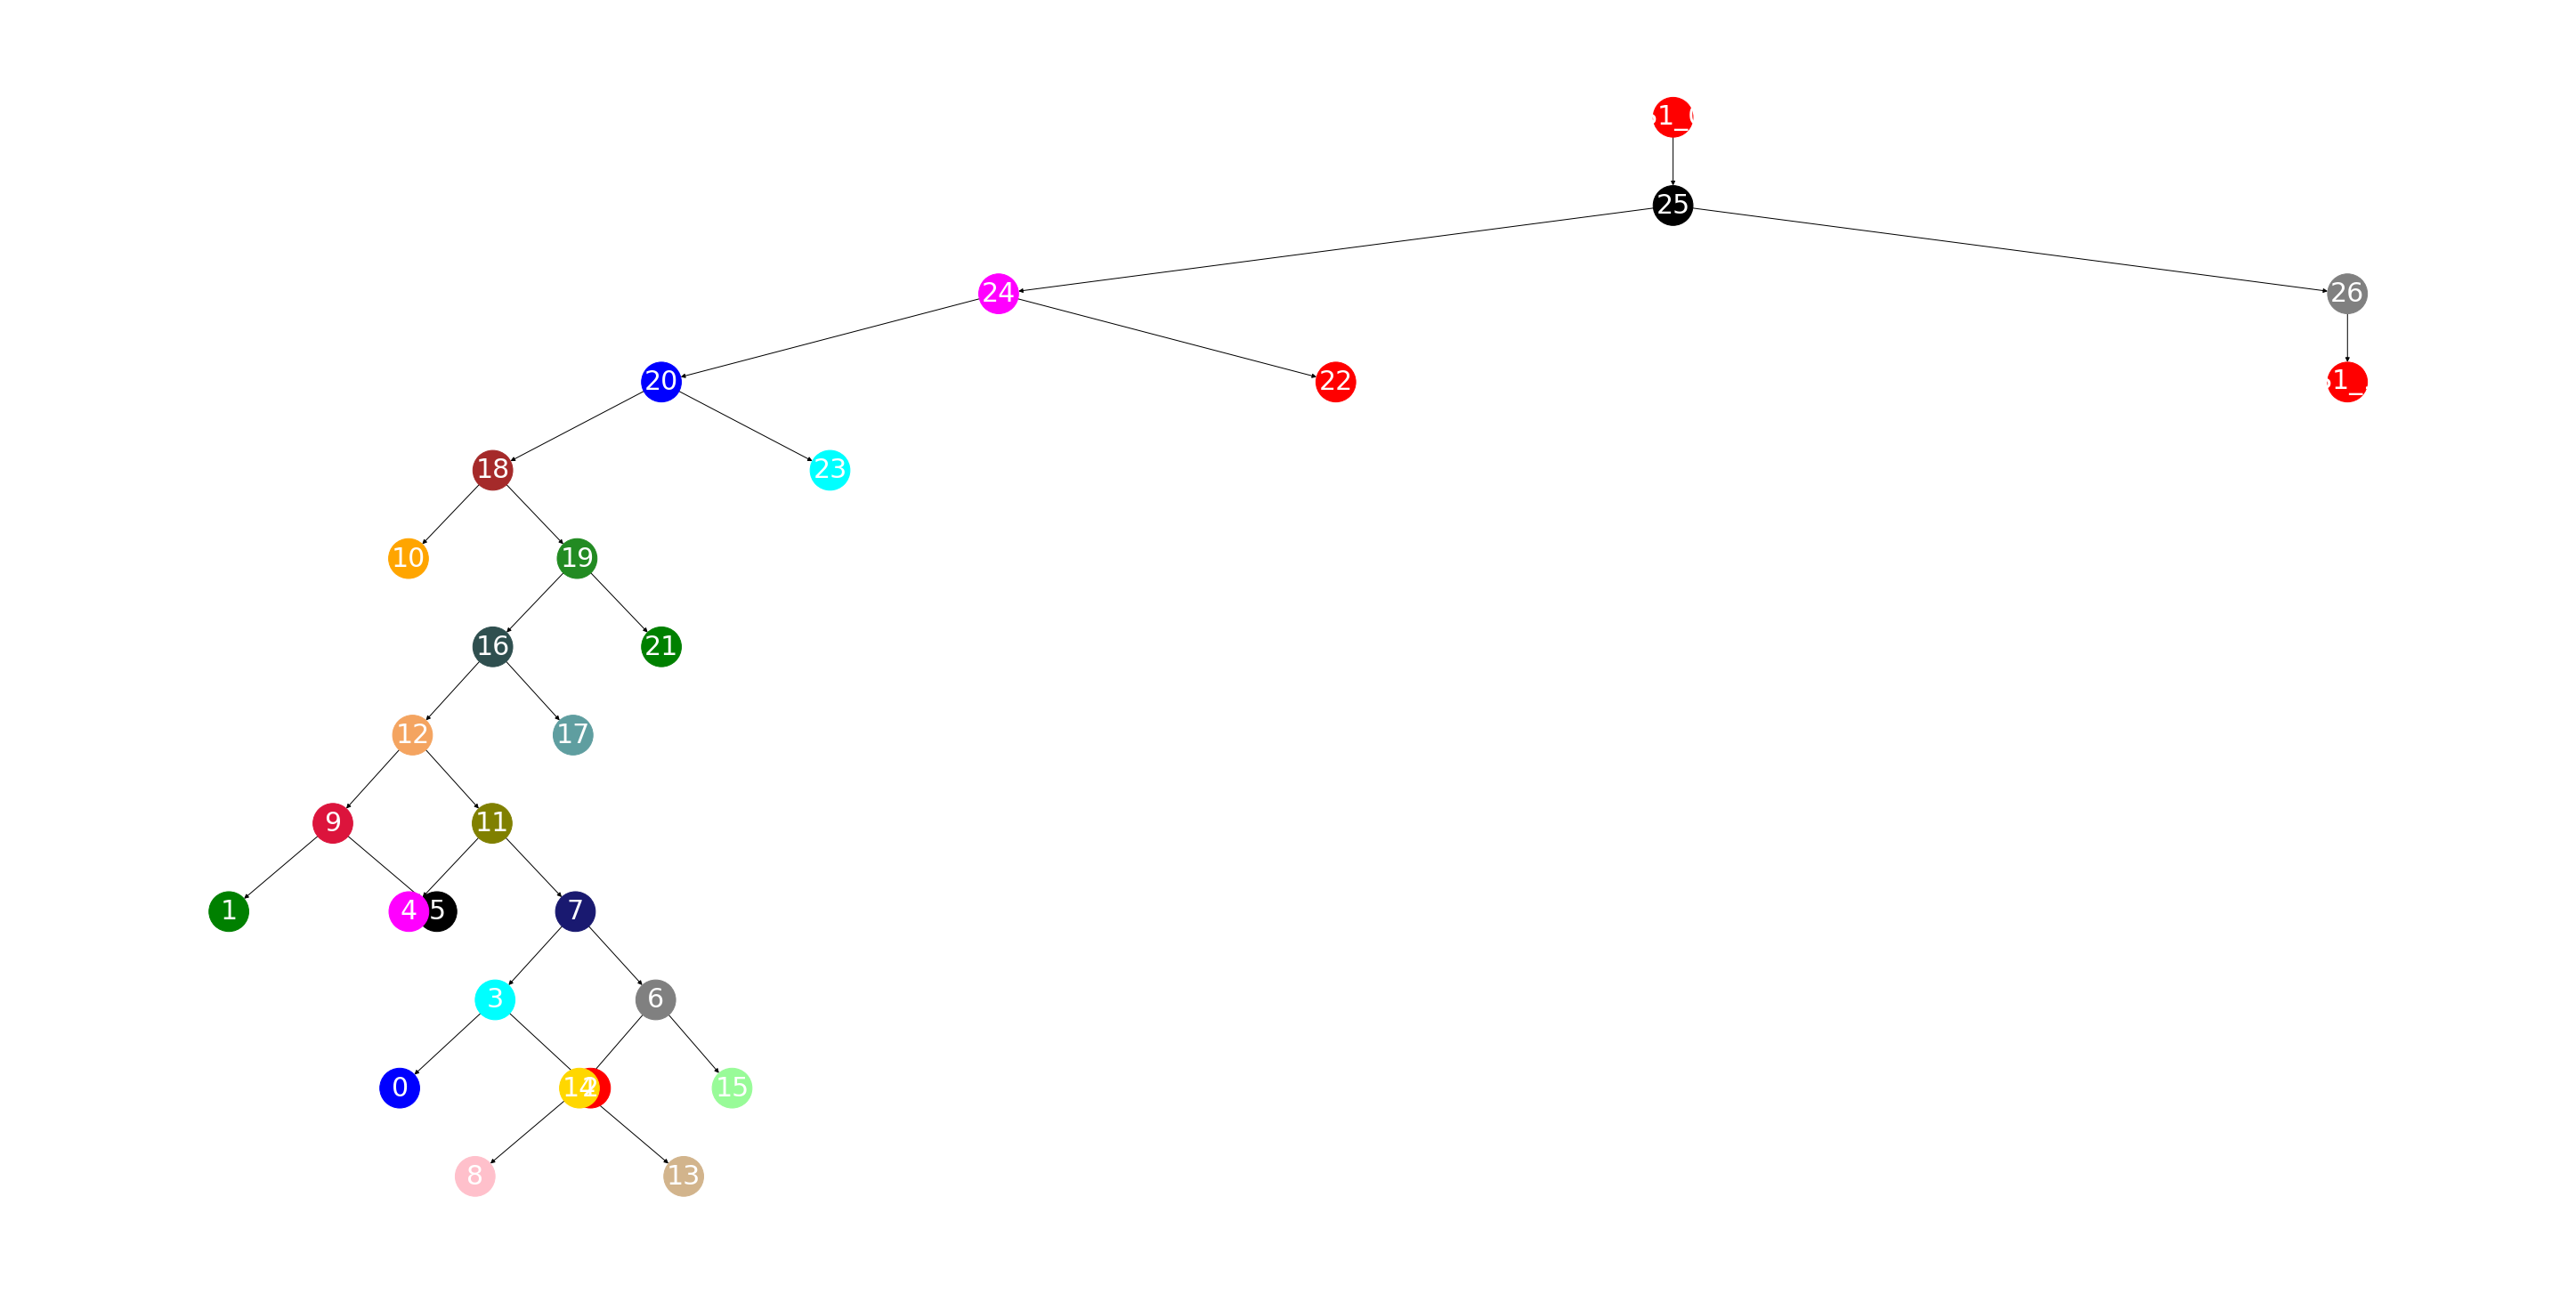

In [29]:
nviz.plot_limb_concept_network_2D(neuron_obj_original,
                                 ret_col)

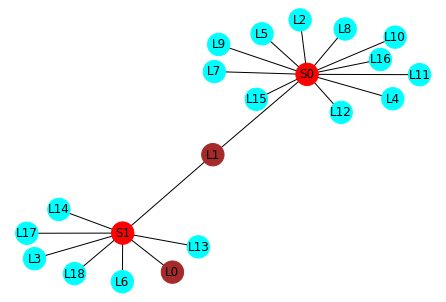

In [18]:
nviz.plot_soma_limb_concept_network(neuron_obj_original)

In [ ]:
nviz.visualize_neuron_lite(neuron_obj_original)

# Splitting the Neuron

multi_soma_limbs = [1]
multi_touch_limbs = [0 1]


 -------- Working on limb 0------------
Starting combinations to process = [[25 26]]


---- working on disconnecting 25 and 26
---- This disconnects S1_0 from S1_1  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [25, 26]

 --------- START OF GET BEST EDGE --------- 
Path was only 2 segments ([25 26]) so just cutting them
edges_to_delete (cut_limb_network) = [[25, 26]]
edges_to_create = []
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
Comp 1 = {26}
curr_limb_copy.deleted_edges = [[25, 26]]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [[25, 26]], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECT

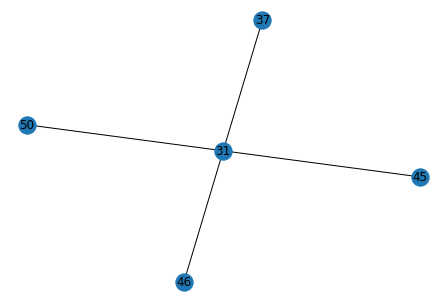

match_branches = [[31, 37]]
edges_to_delete (resolve crossover) = [[31, 45], [31, 46], [31, 50], [37, 45], [37, 46], [37, 50], [45, 46], [45, 50], [46, 50]]
edges_to_create (resolve crossover) = [[31, 37]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = [(32, 31), (31, 37), (37, 34), (34, 33)]
G.nodes() = [32, 31, 37, 34, 33]
nx.number_connected_components(G) after = 1
NOT USING the resolve crossover delete edges because not help resolve the cut
Skipping endnode 32 because skeletal distance was 947.7146379360216 and threshold was 2500
skip_nodes = [32]

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [31 37]: curr_angle = 16.96
  Edge: [37 34]: curr_angle = 10.82
  Edge: [34 33]: curr_angle = 36.82

Total time for doubling_back = 0.11107373237609863

Attempting the width jump check (ARTIFICIALLY ATTEMPTING FROM BOTH SIDES)
width_jump_threshold = 200
  Edge: [31 37]: jump = 182.24
  Edge: [37 34]: jump = 255.28
Adding error edge [37 34] because width jump was 255.27535002220134
  Edge: [34 33]: jump = 102.44
Total time for width = 0.07582259178161621
first_error_sizes = [255.27535002220134, -inf], first_error_locations = [1, inf], winning_path = 0
coordinate_branches = [34, 37, 38]
34 = red
37 = aqua
38 = purple
Angle between 34 and 37 = 16.94 
Angle between 34 and 38 = 75.13 
Angle between 37 and 38 = 94.82 
Final Matches = [[34, 37]]
matched_branches_revised = [[34, 37]]
Original graph


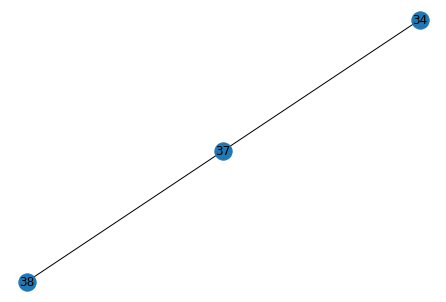

match_branches = [[34, 37]]
edges_to_delete (resolve crossover) = [[34, 38], [37, 38]]
edges_to_create (resolve crossover) = [[34, 37]]
Rejecting creating edge [34, 37] becuase did not involve only 1 node in the deleted edge
edges_to_delete (cut_limb_network) = [array([34, 37]), array([34, 38]), array([37, 38])]
edges_to_create = []
Number of connected components = 4
Comp 0 = {0, 33, 34, 1, 4, 8, 9}
Comp 1 = {2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61}
Comp 2 = {38}
Comp 3 = {44}
curr_limb_copy.deleted_edges = [array([34, 37]), array([34, 38]), array([37, 38])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([34, 37]), array([34, 38]), array([37, 38])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFOR

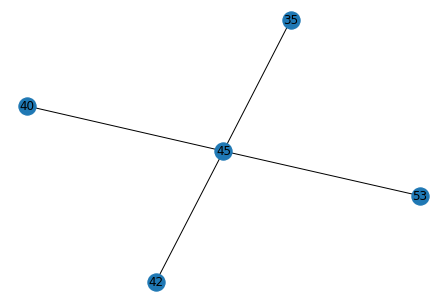

match_branches = [[42, 45]]
edges_to_delete (resolve crossover) = [[35, 40], [35, 42], [35, 45], [35, 53], [40, 42], [40, 45], [40, 53], [42, 53], [45, 53]]
edges_to_create (resolve crossover) = [[42, 45]]
curr_limb.deleted_edges 5 =[array([34, 37]), array([34, 38]), array([37, 38])]
nx.number_connected_components(G) before = 1
G.edges() = [(32, 31), (31, 45), (45, 42)]
G.nodes() = [32, 31, 45, 42]
nx.number_connected_components(G) after = 1
NOT USING the resolve crossover delete edges because not help resolve the cut
Picking [ 962289.5  762763.  1052280. ] high degree coordinates to cut
curr_limb.deleted_edges 4=[array([34, 37]), array([34, 38]), array([37, 38])]
coordinate_branches = [31, 37, 45, 46, 50]
31 = red
37 = aqua
45 = purple
46 = green
Angle between 31 and 37 = 19.6 
Angle between 31 and 45 = 147.53 
Angle between 31 and 46 = 35.34 
Angle between 31 and 50 = 89.15 
Angle between 37 and 45 = 47.77 
Angle between 37 and 46 = 130.06 
Angle between 37 and 50 = 71.36 
Angle betw

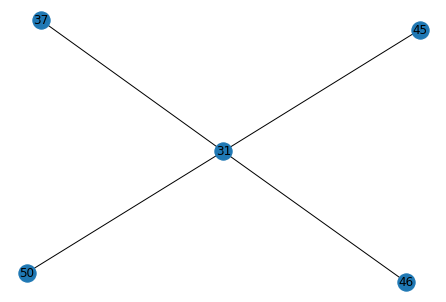

match_branches = [[31, 37]]
edges_to_delete (resolve crossover) = [[31, 45], [31, 46], [31, 50], [37, 45], [37, 46], [37, 50], [45, 46], [45, 50], [46, 50]]
edges_to_create (resolve crossover) = [[31, 37]]
curr_limb.deleted_edges 5 =[array([34, 37]), array([34, 38]), array([37, 38])]
nx.number_connected_components(G) before = 1
G.edges() = [(32, 31), (45, 42)]
G.nodes() = [32, 31, 45, 42]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 32 because skeletal distance was 947.7146379360216 and threshold was 2500
skip_nodes = [32]
edges_to_delete (cut_limb_network) = [[31, 45], [31, 46], [31, 50], [37, 45], [37, 46], [37, 50], [45, 46], [45, 50], [46, 50]]
edges_to_create = [[31, 37]]
Number of connected components = 9
Comp 0 = {0, 33, 34, 1, 4, 8, 9}
Comp 1 = {32, 19, 37, 31}
Comp 2 = {38}
Comp 3 = {2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 35, 36, 39, 

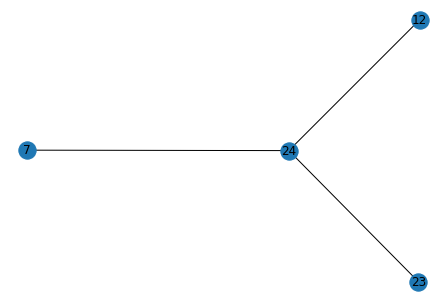

match_branches = []
edges_to_delete (resolve crossover) = [[7, 12], [7, 23], [7, 24], [12, 23], [12, 24], [23, 24]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[array([34, 37]), array([34, 38]), array([37, 38]), [31, 45], [31, 46], [31, 50], [37, 45], [37, 46], [37, 50], [45, 46], [45, 50], [46, 50]]
nx.number_connected_components(G) before = 1
G.edges() = [(42, 40), (40, 24), (12, 10), (10, 18), (18, 30), (30, 51)]
G.nodes() = [42, 40, 24, 12, 10, 18, 30, 51]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 51 because skeletal distance was 670.276246288351 and threshold was 2500
skip_nodes = [51]
edges_to_delete (cut_limb_network) = [[7, 12], [7, 23], [7, 24], [12, 23], [12, 24], [23, 24]]
edges_to_create = []
Number of connected components = 14
Comp 0 = {0, 33, 34, 1, 4, 8, 9}
Comp 1 = {32, 19, 37, 31}
Comp 2 = {38}
Comp 3 = {3, 11, 16, 17, 20, 21, 22, 24, 25, 26, 27, 28, 

In [31]:
split_results = pru.multi_soma_split_suggestions(neuron_obj_original,
                                                )

In [32]:
nviz.plot_split_suggestions_per_limb(neuron_obj_original,
                                    split_results)



-------- Suggestions for Limb 0------

 Working on visualization type: mesh

 Working on visualization type: skeleton




-------- Suggestions for Limb 1------
Only 2 skeleton nodes so cannot do smoothing

 Working on visualization type: mesh

 Working on visualization type: skeleton


In [33]:
(neuron_list,
neuron_list_errored_limbs_area,
 neuron_list_errored_limbs_skeletal_length,
neuron_list_n_multi_soma_errors,
neuron_list_n_same_soma_errors) = pru.split_neuron(neuron_obj_original,
                limb_results=split_results,
                               verbose=False,
                                return_error_info=True
                                    )



using precomputed split suggestions
Only 2 skeleton nodes so cannot do smoothing
Concept graph size was 1 or less so returning original
Only 2 skeleton nodes so cannot do smoothing
There were more not exactly one starting dictinoary: [{'starting_soma': 0, 'starting_node': 33, 'starting_endpoints': array([[ 960433.,  779071., 1048055.],
       [ 960655.,  785093., 1049420.]]), 'starting_coordinate': array([ 960655.,  785093., 1049420.]), 'touching_soma_vertices': TrackedArray([[ 961759.6,  785439.1, 1049105. ],
              [ 961716. ,  785211. , 1050105. ],
              [ 961267.1,  785684.4, 1050876. ],
              [ 961735.2,  785596.9, 1049346. ],
              [ 960414.7,  785689.8, 1051026. ],
              [ 961598.1,  785353.4, 1050543. ],
              [ 961657.2,  785492.6, 1049617. ],
              [ 960183. ,  785736. , 1050777. ],
              [ 959723.6,  785722.8, 1049950. ],
              [ 960687. ,  785578.5, 1051082. ],
              [ 961712.9,  785429.9, 105024

curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7f7c0935b438>]}
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7f7c0935b0f0>]}
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7f7c30799b70>]}
--- 4) Finshed generating Limb objects and adding them to concept graph: 3.531965732574463
--- 5) SKIPPING Doing the adaptive mesh correspondence on the meshparty preprocessing ---
--- 6) SKIPPING Using the computed_attribute_dict to populate neuron attributes ---
self.n_limbs = 11
7) Calculating the spines for the neuorn if do not already exist
Total time for neuron instance creation = 7.470005989074707


------ Working on Soma 1 -------
limb_neighbors = [0, 1, 3, 6, 13, 14, 17, 18, 19, 21]
limb_neighbors BEFORE error limbs removed = [0, 1, 3, 6, 13, 14, 17, 18, 19, 21]
limb_neighbors AFTER error limbs removed = [ 0  3  6 13 14 17 18 19 21]
curr_n_multi_soma_limbs_cancelled = 1
curr_n_same_soma_limbs_canc

In [34]:
print(f" # of neurons = {len(neuron_list)}")
print(f"neuron_list_errored_limbs_area = {neuron_list_errored_limbs_area}")
print(f"neuron_list_errored_limbs_skeletal_length = {neuron_list_errored_limbs_skeletal_length}")
print(f"neuron_list_n_multi_soma_errors = {neuron_list_n_multi_soma_errors}")
print(f"neuron_list_n_same_soma_errors = {neuron_list_n_same_soma_errors}")

 # of neurons = 2
neuron_list_errored_limbs_area = [[1087.3152321429147], [1087.3152321429147]]
neuron_list_errored_limbs_skeletal_length = [[559773.9075237958], [559773.9075237958]]
neuron_list_n_multi_soma_errors = [1, 1]
neuron_list_n_same_soma_errors = [1, 1]


In [35]:
neuron_obj_1 = neuron_list[0]
nviz.visualize_neuron_lite(neuron_obj_1)


 Working on visualization type: mesh


In [36]:
neuron_obj_2 = neuron_list[1]
nviz.visualize_neuron_lite(neuron_obj_2)


 Working on visualization type: mesh


# Iterating through the Neurons

In [40]:
import copy
import time
neuron_obj = copy.deepcopy(neuron_obj_2)

debug_time = True
verbose = True

# Step 1: Axon Classification

In [41]:
filter_time = time.time()

axon_limb_branch_dict,axon_angles = clu.axon_classification(neuron_obj,
                                                        return_error_labels=False,
                                                        verbose=False,
                                                        plot_axons=False,
                                                        label_axon_errors=True,
                                                        return_axon_angles=True)

if debug_time:
    print(f"Axon Classification = {time.time() - filter_time}")
    filter_time = time.time()


Phase 2: Working on Limb L2

Phase 2: Working on Limb L3

Phase 2: Working on Limb L4

Phase 2: Working on Limb L5
candidate_nodes = [ 4  8 14 15]
non_axon_branches_on_subgraph = [8]
endnodes_to_test BEFORE FILTER = [193 300]
candidate_nodes = [ 0  1  2  3  4  5  6  7  9 11 12 13 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]
non_axon_branches_on_subgraph = []
endnodes_to_test BEFORE FILTER = [3624 4669]
candidate_nodes = [ 4 10]
non_axon_branches_on_subgraph = []
endnodes_to_test BEFORE FILTER = [120]
candidate_nodes = [ 1  3  4  5  6  7 10 12 15 16 17 18]
non_axon_branches_on_subgraph = []
endnodes_to_test BEFORE FILTER = [  0 495 625 698]
candidate_nodes = [0 2 5 8 9]
non_axon_branches_on_subgraph = []
endnodes_to_test BEFORE FILTER = [649]
candidate_nodes = [ 5 11 13 14]
non_axon_branches_on_subgraph = []
endnodes_to_test BEFORE FILTER = [398 431]
Axon Classification = 21.566526889801025


In [43]:
import neuron_searching as ns
axon_limb_branch_dict = ns.query_neuron_by_labels(neuron_obj,
                                                 matching_labels=["axon"])
nviz.plot_limb_branch_dict(neuron_obj,
                          axon_limb_branch_dict)


 Working on visualization type: mesh


In [ ]:
axon_like_limb_branch_dict = ns.query_neuron_by_labels(neuron_obj,
                                                 matching_labels=["axon-like"])
nviz.plot_limb_branch_dict(neuron_obj,
                          axon_like_limb_branch_dict)

# Classify the Neuron Cell Type

In [ ]:
clu = reload(clu)

In [45]:
filter_time = time.time()

(inh_exc_class,
             spine_category,
             axon_angles,
             n_axons,
             n_apicals,
             neuron_spine_density,
             n_branches_processed,
             skeletal_length_processed,
             n_branches_in_search_radius,
             skeletal_length_in_search_radius
             ) = clu.inhibitory_excitatory_classifier(neuron_obj,
                                                return_spine_classification=True,
                                                return_axon_angles=True,
                                                 return_n_axons=True,
                                                 return_n_apicals=True,
                                                 return_spine_statistics=True,
                                                     axon_limb_branch_dict_precomputed=axon_limb_branch_dict,
                                                axon_angles_precomputed=axon_angles)

if debug_time:
    print(f"Inhibitory Excitatory Classification = {time.time() - filter_time}")
    filter_time = time.time()

spine_category = densely_spined
Using pre-computed axon classification for contains_excitatory_axon
axon_limb_branch_dict = {'L4': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 16, 17, 18])}
axon_angles = {4: {0: 172.19816392583272, 1: 111.39215647100816}}
Inhibitory Excitatory Classification = 7.59424614906311


In [46]:
if verbose:
    print("\n -- Cell Type Classification Results --")
    print(f"inh_exc_class={inh_exc_class}")
    print(f"spine_category={spine_category}")
    print(f"axon_angles={axon_angles}")
    print(f"n_axons={n_axons}")
    print(f"n_apicals={n_apicals}")
    print(f"neuron_spine_density={neuron_spine_density}")
    print(f"n_branches_processed={n_branches_processed}")
    print(f"skeletal_length_processed={skeletal_length_processed}")
    print(f"n_branches_in_search_radius={n_branches_in_search_radius}")
    print(f"skeletal_length_in_search_radius={skeletal_length_in_search_radius}")



 -- Cell Type Classification Results --
inh_exc_class=excitatory
spine_category=densely_spined
axon_angles={4: {0: 172.19816392583272, 1: 111.39215647100816}}
n_axons=1
n_apicals=1
neuron_spine_density=0.000535183621296964
n_branches_processed=10
skeletal_length_processed=660504.4911708552
n_branches_in_search_radius=114
skeletal_length_in_search_radius=2873882.479413888


# Developing The Filtering Pipeline

In [66]:
exc_axon_on_dendrite_merges_filter = pru.make_filter_dict("axon_on_dendrite_merges",
                                         pru.filter_away_axon_on_dendrite_merges,
                                         dict(use_pre_existing_axon_labels=True)
                                              
                                        )

exc_low_branch_clusters_filter = pru.make_filter_dict("low_branch_clusters",
                                        pru.filter_away_low_branch_length_clusters,
                                        dict())

exc_dendrite_on_axon_merges_filter = pru.make_filter_dict("dendrite_on_axon_merges",
                                                     pru.filter_away_dendrite_on_axon_merges,
                                                      dict(use_pre_existing_axon_labels=True)
                                                     )
exc_double_back_and_width_change_filter = pru.make_filter_dict("double_back_and_width_change",
                                                     pru.filter_away_large_double_back_or_width_changes,
                                                      dict(perform_double_back_errors=True,
                                                          skip_double_back_errors_for_axon=True,
                                                          double_back_threshold = 140)
                                                     )
exc_high_degree_coordinates_filter = pru.make_filter_dict("high_degree_coordinates",
                                                     pru.filter_away_high_degree_coordinates,
                                                      dict(axon_dependent=True)
                                                     )

exc_crossovers_filter = pru.make_filter_dict("crossovers",
                                                     pru.filter_away_crossovers,
                                                      dict(axon_dependent=True,
                                                          match_threshold = 30)
                                                     )
exc_filters = [exc_axon_on_dendrite_merges_filter,
              exc_low_branch_clusters_filter,
              exc_dendrite_on_axon_merges_filter,
              exc_double_back_and_width_change_filter,
              exc_high_degree_coordinates_filter,
              exc_crossovers_filter,]


[{'filter_name': 'axon_on_dendrite_merges',
  'filter_function': <function proofreading_utils.filter_away_axon_on_dendrite_merges(neuron_obj, perform_deepcopy=True, axon_merge_error_limb_branch_dict=None, perform_axon_classification=False, use_pre_existing_axon_labels=False, return_error_info=True, plot_limb_branch_filter_away=False, plot_limb_branch_filter_with_disconnect_effect=False, plot_final_neuron=False, verbose=False, **kwargs)>,
  'filter_kwargs': {'use_pre_existing_axon_labels': True}},
 {'filter_name': 'low_branch_clusters',
  'filter_function': <function proofreading_utils.filter_away_low_branch_length_clusters(neuron_obj, max_skeletal_length=8000, min_n_nodes_in_cluster=4, return_error_info=False, plot_limb_branch_filter_with_disconnect_effect=False, plot_limb_branch_filter_away=False, plot_final_neuron=False, **kwargs)>,
  'filter_kwargs': {}},
 {'filter_name': 'dendrite_on_axon_merges',
  'filter_function': <function proofreading_utils.filter_away_dendrite_on_axon_merges

In [67]:
inh_low_branch_clusters_filter = pru.make_filter_dict("low_branch_clusters",
                                        pru.filter_away_low_branch_length_clusters,
                                        dict())
inh_high_degree_coordinates_filter = pru.make_filter_dict("high_degree_coordinates",
                                                     pru.filter_away_high_degree_coordinates,
                                                      dict(axon_dependent=True)
                                                     )
inh_crossovers_filter = pru.make_filter_dict("crossovers",
                                                     pru.filter_away_crossovers,
                                                      dict(axon_dependent=True,
                                                          match_threshold = 30)
                                                     )

inh_double_back_and_width_change_filter = pru.make_filter_dict("double_back_and_width_change",
                                                     pru.filter_away_large_double_back_or_width_changes,
                                                      dict(perform_double_back_errors=False,
                                                          skip_double_back_errors_for_axon=True)
                                                     )



inh_filters = [inh_low_branch_clusters_filter,
              inh_high_degree_coordinates_filter,
               inh_crossovers_filter,
               inh_double_back_and_width_change_filter
              ]

inh_filters

[{'filter_name': 'low_branch_clusters',
  'filter_function': <function proofreading_utils.filter_away_low_branch_length_clusters(neuron_obj, max_skeletal_length=8000, min_n_nodes_in_cluster=4, return_error_info=False, plot_limb_branch_filter_with_disconnect_effect=False, plot_limb_branch_filter_away=False, plot_final_neuron=False, **kwargs)>,
  'filter_kwargs': {}},
 {'filter_name': 'high_degree_coordinates',
  'filter_function': <function proofreading_utils.filter_away_high_degree_coordinates(neuron_obj, return_error_info=False, plot_limb_branch_filter_with_disconnect_effect=False, plot_limb_branch_filter_away=False, plot_final_neuron=False, **kwargs)>,
  'filter_kwargs': {'axon_dependent': True}},
 {'filter_name': 'crossovers',
  'filter_function': <function proofreading_utils.filter_away_crossovers(neuron_obj, return_error_info=False, plot_limb_branch_filter_with_disconnect_effect=False, plot_limb_branch_filter_away=False, plot_final_neuron=False, **kwargs)>,
  'filter_kwargs': {'ax

In [74]:
pru = reload(pru)

In [77]:
o_neuron, o_results = pru.apply_proofreading_filters_to_neuron(input_neuron = neuron_obj,
                                    filter_list = pru.get_exc_filters(),
                                    plot_limb_branch_filter_with_disconnect_effect=False,
                                    plot_limb_branch_filter_away=False,
                                    plot_final_neuron=False,

                                    return_error_info=True,
                                     verbose=False,
)

----------------------- Running Filter ------------------


----Working on seperate_graph 0----


---------Working on soma_idx = 0, soma_group_idx 0, endpt = [ 955316.  742527. 1046560.]---------
Starting_edge inside branches_to_conept = [[ 953322.  741003. 1046440.]
 [ 955316.  742527. 1046560.]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [24]
printing out current edge:
[[ 955316.  742527. 1046560.]
 [ 953322.  741003. 1046440.]]
edge_endpoints_to_process was empty so exiting loop after 24 iterations
starting_node in concept map (that should match the starting edge) = 23
Total time for branches to concept conversion = 0.19308018684387207

Done generating concept network 




----Working on seperate_graph 0----


---------Working on soma_idx = 0, soma_group_idx 0, endpt = [ 968034.73636364  750382.86363636 1049582.36363636]---------
Starting_edge inside branches_to_conept = [[ 968034.73636364  750382.86363636 1049582.36363636]
 [ 97

limb_branch_dict was empty so returning original neuron
----------------------- FINISHED Running Filter ------------------


----------------------- Running Filter ------------------
limb_branch_dict was empty so returning original neuron
----------------------- FINISHED Running Filter ------------------


----------------------- Running Filter ------------------
limb_branch_dict was empty so returning original neuron
----------------------- FINISHED Running Filter ------------------




In [76]:
nviz.visualize_neuron_lite(o_neuorn)


 Working on visualization type: mesh
